# Objective:

**To classify food reviews into positive or negative using K Nearest Neghbors algorithm.**

This is a continuation of my ongoing study of the Amazon Food Reviews data available on Kaggle. Let's see how KNN performs on this dataset. As usual, let's begin by importing the libraries we need.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
from google.colab import drive
import os
import sqlite3

Connect to google drive to load the cleaned dataframe.

In [0]:
drive.mount('/gdrive')

I had stored a dataframe with cleaned text reviews from the last excercise on my Google Drive. So there's no need to perform data cleaning again. The column 'cleaned_text' is free from stopwords, punctuation marks, HTML tags, and duplicate entries.

I simply need to load it. Let's do that by connecting this Google Colab environment with my Google Drive.

In [4]:
os.listdir('/gdrive/My Drive/amazon')

['avg_w2v_nparray_3kcorpus_50dim.pkl',
 'pickled_3k_reviews_tsne_tfidf_1gram.pkl',
 'pickled_3k_reviews_tsne_bigram.pkl',
 'X_scaled_standardized_3k_bigram_bow_nparray.pkl',
 'pickled_3k_reviews_tsne_bow.pkl',
 'reviews_cleaned_final.sqlite',
 'database_deduplicated.sqlite',
 'database.sqlite']

In [5]:
con = sqlite3.connect('/gdrive/My Drive/amazon/reviews_cleaned_final.sqlite')
df_full_clean = pd.read_sql('select * from Reviews;', con)
df_full_clean.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanut peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citru g...


### Sorting by Timestamp

The reviews are likely to have a temporal structure. If we train our model on randomly sampled data, this structural information will be lost. Therefore, sort the dataframe by timestamp and select a subset from it from a contiguous timespan.

In [6]:
df_full_clean.sort_values(by=['Time'], ascending=True, inplace=True)
df_full_clean.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
117924,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
117901,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
298792,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
169281,212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...


The data is now sorted by time. Since this is a huge database, I'll have to sample only a small fraction of it, due to hardware limitations. 

In [7]:
df_full_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 117924 to 107253
Data columns (total 12 columns):
index                     364171 non-null int64
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null object
Time                      364171 non-null int64
Summary                   364171 non-null object
Text                      364171 non-null object
cleaned_text              364171 non-null object
dtypes: int64(5), object(7)
memory usage: 36.1+ MB


There are 364k reviews in the dataframe. Let's select the first 10,000 reviews.

In [96]:
df = df_full_clean[:10000][['Time', 'cleaned_text', 'Score']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 117924 to 59994
Data columns (total 3 columns):
Time            10000 non-null int64
cleaned_text    10000 non-null object
Score           10000 non-null object
dtypes: int64(1), object(2)
memory usage: 312.5+ KB


In [97]:
df.head()

,Time,cleaned_text,Score
117924,939340800,b'witti littl book make son laugh loud recit c...,positive
117901,940809600,b'rememb see show air televis year ago child s...,positive
298792,944092800,b'beetlejuic well written movi everyth excel a...,positive
169281,944438400,b'twist rumplestiskin captur film star michael...,positive
298791,946857600,b'beetlejuic excel funni movi keaton hilari wa...,positive


Let's see how the +/- reviews are distributed. The positive reviews are expected to be more than the negative ones.

In [98]:
df['Score'].value_counts()

positive    8868
negative    1132
Name: Score, dtype: int64

Let's map the score column in the dataframe

* positive : 1
* negative : 0


In [0]:
df['Score'] = df['Score'].map({'positive':1,'negative':0})

## Vector Representation of Text data


Let's convert the reviews into their vector representations. Following methods will be used to vectorize text -

* BoW
* Tfidf
* Avg. W2V
* Tfidf weighted W2V

For BoW and Tfidf, since the number of features/dimensions will be huge, I'll test KNN first on uncompressed data (all dimensions) and then, reduce the dimensions using PCA and t-SNE and again test KNN on the new data. I'll test both **kd_tree** and **brute** algorithm in scikit-learn's implementation of KNN.

### Bag of Words (BoW)

Import the required class from sklearn.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [0]:
bow = CountVectorizer()
bow_sparse_matrix = bow.fit_transform(df['cleaned_text'].values)

In [102]:
type(bow_sparse_matrix)

scipy.sparse.csr.csr_matrix

In [103]:
print('The shape of bow_sparse_matrix is: {}'.format(bow_sparse_matrix.get_shape))

The shape of bow_sparse_matrix is: <bound method spmatrix.get_shape of <10000x14331 sparse matrix of type '<class 'numpy.int64'>'
	with 312582 stored elements in Compressed Sparse Row format>>


There are 10,000 rows for 10,000 reviews as expected. The number features in 1-gram BoW representation is 14331. That's a lot!

We can reduce the dimensions further by applying techniques such as PCA and t-SNE. We'll have to do that since KNN doesn't work well when the number features is in thousands.

First, let's convert the sparse matrix into a dense matrix.

In [0]:
bow_regular_matrix = bow_sparse_matrix.toarray()

In [105]:
bow_regular_matrix.shape

(10000, 14331)

Now let's apply KNN on this dataset, without reducing the dimensions.

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

In [107]:
y = np.array(df['Score'])
y[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [108]:
y[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

Divide the data into training and test sets.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(bow_regular_matrix, y, test_size=0.3,random_state=3,shuffle=False)

In [110]:
print('Shape of X_train is {}.'.format(X_train.shape))
print('Shape of X_test is {}.'.format(X_test.shape))
print('Shape of y_train is {}.'.format(y_train.shape))
print('Shape of y_test is {}.'.format(y_test.shape))

Shape of X_train is (7000, 14331).
Shape of X_test is (3000, 14331).
Shape of y_train is (7000,).
Shape of y_test is (3000,).


In [111]:
y_train[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

Following is a function that will give us the accuracy for a number of K values. I'll use this function several times in this notebook. The function takes training data and algorithm (kd_tree or brute) as parameters and returns a dictionary {k : accuracy}

In [0]:
def k_versus_accuracy(X_train, y_train, alg):
    
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.cross_validation import cross_val_score
    
    k_vs_acc = {}
    
    for k in range(3,15,2):
        
        knn = KNeighborsClassifier(n_neighbors = k, weights = 'uniform', algorithm = alg)
        
        k_vs_acc[k] = np.mean(cross_val_score(knn, X_train, y_train, cv = 10))
    
    
    return k_vs_acc 
    

Call the function for BoW without reducing any dimensions, first using the brute algorithm then kd_tree. 

In [113]:
k_vs_acc_uncompressed_brute_BOW = k_versus_accuracy(X_train, y_train, alg='brute')
print('K vs Accuracy for Uncompressed Bag of Words using Brute algorithm...\n {}'.format(k_vs_acc_uncompressed_brute_BOW))

K vs Accuracy for Uncompressed Bag of Words using Brute algorithm...
 {3: 0.8657142857142857, 5: 0.8825714285714286, 7: 0.8858571428571429, 9: 0.8852857142857143, 11: 0.8852857142857143, 13: 0.8847142857142856}


In [114]:
k_vs_acc_uncompressed_kd_BOW = k_versus_accuracy(X_train, y_train, alg='kd_tree')
print('K vs Accuracy for Uncompressed Bag of Words using KD_tree algorithm...\n {}'.format(k_vs_acc_uncompressed_kd_BOW))

K vs Accuracy for Uncompressed Bag of Words using KD_tree algorithm...
 {3: 0.868, 5: 0.8832857142857143, 7: 0.886142857142857, 9: 0.8848571428571429, 11: 0.885142857142857, 13: 0.8848571428571429}


We see that KNN on uncompressed BOW representation gives very similar accuracy for K between (3,13).

Let's select a k and find the accuracy on testing data. Note that the test dataset hasn't been seen by KNN while fitting the model.

In [115]:
knn = KNeighborsClassifier(n_neighbors = 11, weights = 'uniform', algorithm = 'kd_tree')
knn.fit(X_train, y_train)
print('Accuracy for BOW | Uncompressed data')
print('Accuracy on train data: {}'.format(knn.score(X_train, y_train)))
print('Accuracy on test data: {}'.format(knn.score(X_test, y_test)))

Accuracy for BOW | Uncompressed data
Accuracy on train data: 0.8864285714285715
Accuracy on test data: 0.892


Although this accuracy seems good and makes a good first impression, there is a big **caveat** with it. Our original data is heavily class imbalanced. The positive reviews are far greater in number than the negative reviews. And because KNN favors the majority class by design, it is likely misclassifying many of the negative reviews as positve. So let's take this result with a grain of salt.

### Reduce dimensions of BoW using PCA

Now, let's try reducing the dimensions of BoW from 14331 to 50 using PCA, and apply KNN.

In [116]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 50)
X_new_pca = pca.fit_transform(bow_regular_matrix)
print(X_new_pca.shape)

(10000, 50)


Split the new data into train and test sets.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_new_pca, y, test_size=0.3,random_state=3,shuffle=False)

In [118]:
k_vs_acc_pca_brute_BOW = k_versus_accuracy(X_train, y_train, alg='brute')
print('K vs Accuracy for PCA compressed Bag of Words using Brute algorithm...\n {}'.format(k_vs_acc_pca_brute_BOW))

K vs Accuracy for PCA compressed Bag of Words using Brute algorithm...
 {3: 0.8565714285714285, 5: 0.8681428571428572, 7: 0.8737142857142859, 9: 0.8785714285714287, 11: 0.8817142857142857, 13: 0.8822857142857143}


In [119]:
k_vs_acc_pca_kd_BOW = k_versus_accuracy(X_train, y_train, alg='kd_tree')
print('K vs Accuracy for PCA compressed Bag of Words using KD_tree algorithm...\n {}'.format(k_vs_acc_pca_kd_BOW))

K vs Accuracy for PCA compressed Bag of Words using KD_tree algorithm...
 {3: 0.8565714285714285, 5: 0.8681428571428572, 7: 0.8737142857142859, 9: 0.8785714285714287, 11: 0.8817142857142857, 13: 0.8822857142857143}


Again, for data compressed using PCA, KNN gives very similar accuracies for various values of k. Let's pick one value and find the accuracy on test set now.

In [120]:
knn = KNeighborsClassifier(n_neighbors = 13, weights = 'uniform', algorithm = 'kd_tree')
knn.fit(X_train, y_train)
print('Accuracy for BOW | PCA compressed data')
print('Accuracy on train data: {}'.format(knn.score(X_train, y_train)))
print('Accuracy on test data: {}'.format(knn.score(X_test, y_test)))

Accuracy for BOW | PCA compressed data
Accuracy on train data: 0.8874285714285715
Accuracy on test data: 0.8903333333333333


Similar result as before, now let's try compressing the dimensions using t-SNE.

### BoW on t-SNE compressed data.

Reducing the dimensions from 14331 in the original uncompressed data to just 3 using t-SNE. 

In [121]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components = 3, perplexity = 40, learning_rate = 300)

X_new_tsne = tsne.fit_transform(bow_regular_matrix)

print(X_new_tsne.shape)

(10000, 3)


Divide t-SNE reduced data into train and test sets.

In [0]:
X_train,X_test, y_train, y_test = train_test_split(X_new_tsne, y, test_size=0.3,random_state=3,shuffle=False)

In [123]:
k_vs_acc_tsne_brute_BOW = k_versus_accuracy(X_train, y_train, alg='brute')
print('K vs Accuracy for t-SNE compressed Bag of Words using Brute algorithm...\n {}'.format(k_vs_acc_tsne_brute_BOW))

K vs Accuracy for t-SNE compressed Bag of Words using Brute algorithm...
 {3: 0.8629999999999999, 5: 0.8742857142857142, 7: 0.8782857142857143, 9: 0.8785714285714287, 11: 0.8808571428571428, 13: 0.8827142857142858}


In [124]:
k_vs_acc_tsne_kd_BOW = k_versus_accuracy(X_train, y_train, alg='kd_tree')
print('K vs Accuracy for t-SNE compressed Bag of Words using KD_Tree algorithm...\n {}'.format(k_vs_acc_tsne_kd_BOW))

K vs Accuracy for t-SNE compressed Bag of Words using KD_Tree algorithm...
 {3: 0.8629999999999999, 5: 0.8742857142857142, 7: 0.8782857142857143, 9: 0.8785714285714287, 11: 0.8808571428571428, 13: 0.8827142857142858}


Now, let's calculate test accuracies.

In [125]:
knn = KNeighborsClassifier(n_neighbors = 9, weights = 'uniform', algorithm = 'kd_tree')
knn.fit(X_train, y_train)
print('Accuracy for BOW | t-SNE compressed data')
print('Accuracy on train data: {}'.format(knn.score(X_train, y_train)))
print('Accuracy on test data: {}'.format(knn.score(X_test, y_test)))

Accuracy for BOW | t-SNE compressed data
Accuracy on train data: 0.8885714285714286
Accuracy on test data: 0.8926666666666667


***Now, let me plot my findings to summarize the KNN models trained on BOW.***

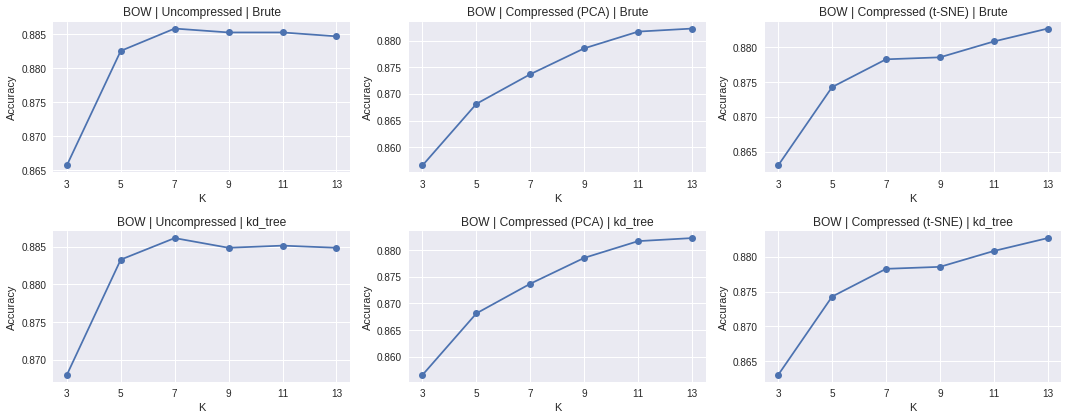

In [126]:
plt.figure(figsize=(15,6))
plt.subplot(2, 3, 1)
plt.title('BOW | Uncompressed | Brute')
plt.plot(list(k_vs_acc_uncompressed_brute_BOW.keys()), list(k_vs_acc_uncompressed_brute_BOW.values()), marker='o')
plt.xticks([3,5,7,9,11,13])
plt.xlabel('K')
plt.ylabel('Accuracy')


plt.subplot(2,3,4)
plt.title('BOW | Uncompressed | kd_tree')
plt.plot(list(k_vs_acc_uncompressed_kd_BOW.keys()), list(k_vs_acc_uncompressed_kd_BOW.values()), marker='o')
plt.xticks(range(3,15,2))
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.tight_layout()

plt.subplot(2,3,2)
plt.title('BOW | Compressed (PCA) | Brute')
plt.plot(list(k_vs_acc_pca_brute_BOW.keys()), list(k_vs_acc_pca_brute_BOW.values()), marker='o')
plt.xticks(range(3,15,2))
plt.xlabel('K')
plt.ylabel('Accuracy')

plt.subplot(2,3,5)
plt.title('BOW | Compressed (PCA) | kd_tree')
plt.plot(list(k_vs_acc_pca_kd_BOW.keys()), list(k_vs_acc_pca_kd_BOW.values()), marker='o')
plt.xticks(range(3,15,2))
plt.xlabel('K')
plt.ylabel('Accuracy')

plt.subplot(2,3,3)
plt.title('BOW | Compressed (t-SNE) | Brute')
plt.plot(list(k_vs_acc_tsne_brute_BOW.keys()), list(k_vs_acc_tsne_brute_BOW.values()), marker='o')
plt.xticks(range(3,15,2))
plt.xlabel('K')
plt.ylabel('Accuracy')

plt.subplot(2,3,6)
plt.title('BOW | Compressed (t-SNE) | kd_tree')
plt.plot(list(k_vs_acc_tsne_kd_BOW.keys()), list(k_vs_acc_tsne_kd_BOW.values()), marker='o')
plt.xticks(range(3,15,2))
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.tight_layout()

Important note: Although the y axis shows significant variance at first glance, the scale on it is very small. i.e. there's very little difference between the highest and the lowerst value on the y  axis. So almost all of these values are equivalent.

### Tfidf vector representation of Text

After BoW, let's run KNN on the Tfidf representation of the reviews. I'm following the same steps as earlier i.e. 

* KNN on uncompressed data
* KNN on data reduced by PCA
* KNN on data reduced by t-SNE

---



In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,1))
tfidf = tfidf_vec.fit_transform(df['cleaned_text'].values)

In [129]:
tfidf.shape

(10000, 14331)

In [130]:
tfidf_vector = tfidf.toarray()
tfidf_vector.shape

(10000, 14331)

In [131]:
type(tfidf_vector)

numpy.ndarray

In [0]:
X_train,X_test, y_train, y_test = train_test_split(tfidf_vector, y, test_size=0.3,random_state=3,shuffle=False)

In [133]:
k_vs_acc_uncompressed_brute_tfidf = k_versus_accuracy(X_train, y_train, alg='brute')
print('K vs Accuracy for Uncompressed Tfidf using Brute algorithm...\n {}'.format(k_vs_acc_uncompressed_brute_tfidf))

K vs Accuracy for Uncompressed Tfidf using Brute algorithm...
 {3: 0.8865714285714285, 5: 0.8932857142857141, 7: 0.894142857142857, 9: 0.8924285714285715, 11: 0.8908571428571429, 13: 0.8904285714285713}


In [134]:
k_vs_acc_uncompressed_kd_tfidf = k_versus_accuracy(X_train, y_train, alg='kd_tree')
print('K vs Accuracy for Uncompressed Tfidf using KD_tree algorithm...\n {}'.format(k_vs_acc_uncompressed_kd_tfidf))

K vs Accuracy for Uncompressed Tfidf using KD_tree algorithm...
 {3: 0.8865714285714285, 5: 0.8932857142857141, 7: 0.894142857142857, 9: 0.8924285714285715, 11: 0.8908571428571429, 13: 0.8904285714285713}


In [135]:
knn = KNeighborsClassifier(n_neighbors = 11, weights = 'uniform', algorithm = 'brute')
knn.fit(X_train, y_train)
print('Accuracy for Tfidf | Uncompressed data')
print('Accuracy on train data: {}'.format(knn.score(X_train, y_train)))
print('Accuracy on test data: {}'.format(knn.score(X_test, y_test)))

Accuracy for Tfidf | Uncompressed data
Accuracy on train data: 0.8982857142857142
Accuracy on test data: 0.901


**PCA on Tfidf**

In [136]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 50)
X_new_pca = pca.fit_transform(tfidf_vector)
print(X_new_pca.shape)

(10000, 50)


In [0]:
X_train,X_test, y_train, y_test = train_test_split(X_new_pca, y, test_size=0.3,random_state=3,shuffle=False)

In [138]:
k_vs_acc_pca_brute_tfidf = k_versus_accuracy(X_train, y_train, alg='brute')
print('K vs Accuracy for PCA compressed Tfidf using Brute algorithm...\n {}'.format(k_vs_acc_pca_brute_tfidf))

K vs Accuracy for PCA compressed Tfidf using Brute algorithm...
 {3: 0.8515714285714285, 5: 0.8704285714285713, 7: 0.8787142857142856, 9: 0.883, 11: 0.8859999999999999, 13: 0.8861428571428572}


In [139]:
k_vs_acc_pca_kd_tfidf = k_versus_accuracy(X_train, y_train, alg='kd_tree')
print('K vs Accuracy for PCA compressed Tfidf using KD_tree algorithm...\n {}'.format(k_vs_acc_pca_kd_tfidf))

K vs Accuracy for PCA compressed Tfidf using KD_tree algorithm...
 {3: 0.8515714285714285, 5: 0.8704285714285713, 7: 0.8787142857142856, 9: 0.883, 11: 0.8859999999999999, 13: 0.8861428571428572}


In [140]:
knn = KNeighborsClassifier(n_neighbors = 11, weights = 'uniform', algorithm = 'brute')
knn.fit(X_train, y_train)
print('Accuracy for Tfidf | PCA compressed data')
print('Accuracy on train data: {}'.format(knn.score(X_train, y_train)))
print('Accuracy on test data: {}'.format(knn.score(X_test, y_test)))

Accuracy for Tfidf | PCA compressed data
Accuracy on train data: 0.8975714285714286
Accuracy on test data: 0.8886666666666667


**t-SNE on Tfidf**

In [141]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 3, perplexity = 45, learning_rate = 300)

X_new_tsne = tsne.fit_transform(tfidf_vector)

print(X_new_tsne.shape)

(10000, 3)


In [0]:
X_train,X_test, y_train, y_test = train_test_split(X_new_tsne, y, test_size=0.3,random_state=3,shuffle=False)

In [143]:
k_vs_acc_tsne_brute_tfidf = k_versus_accuracy(X_train, y_train, alg='brute')
print('K vs Accuracy for tsne compressed Tfidf using Brute algorithm...\n {}'.format(k_vs_acc_tsne_brute_tfidf))

K vs Accuracy for tsne compressed Tfidf using Brute algorithm...
 {3: 0.875, 5: 0.8865714285714287, 7: 0.8881428571428571, 9: 0.8897142857142857, 11: 0.8901428571428571, 13: 0.8908571428571428}


In [144]:
k_vs_acc_tsne_kd_tfidf = k_versus_accuracy(X_train, y_train, alg='kd_tree')
print('K vs Accuracy for tsne compressed Tfidf using Brute algorithm...\n {}'.format(k_vs_acc_tsne_kd_tfidf))

K vs Accuracy for tsne compressed Tfidf using Brute algorithm...
 {3: 0.875, 5: 0.8865714285714287, 7: 0.8881428571428571, 9: 0.8897142857142857, 11: 0.8901428571428571, 13: 0.8908571428571428}


In [145]:
knn = KNeighborsClassifier(n_neighbors = 11, weights = 'uniform', algorithm = 'kd_tree')
knn.fit(X_train, y_train)
print('Accuracy for Tfidf | t-SNE compressed data')
print('Accuracy on train data: {}'.format(knn.score(X_train, y_train)))
print('Accuracy on test data: {}'.format(knn.score(X_test, y_test)))

Accuracy for Tfidf | t-SNE compressed data
Accuracy on train data: 0.897
Accuracy on test data: 0.8916666666666667


Summarizing K vs Accuracy for Tfidf representation through a plot

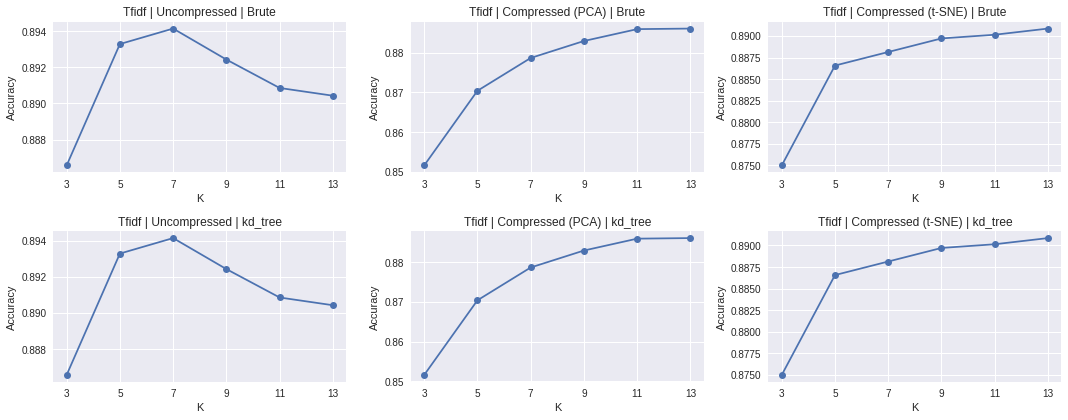

In [146]:
plt.figure(figsize=(15,6))
plt.subplot(2, 3, 1)
plt.title('Tfidf | Uncompressed | Brute')
plt.plot(list(k_vs_acc_uncompressed_brute_tfidf.keys()), list(k_vs_acc_uncompressed_brute_tfidf.values()), marker='o')
plt.xticks([3,5,7,9,11,13])
plt.xlabel('K')
plt.ylabel('Accuracy')


plt.subplot(2,3,4)
plt.title('Tfidf | Uncompressed | kd_tree')
plt.plot(list(k_vs_acc_uncompressed_kd_tfidf.keys()), list(k_vs_acc_uncompressed_kd_tfidf.values()), marker='o')
plt.xticks(range(3,15,2))
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.tight_layout()

plt.subplot(2,3,2)
plt.title('Tfidf | Compressed (PCA) | Brute')
plt.plot(list(k_vs_acc_pca_brute_tfidf.keys()), list(k_vs_acc_pca_brute_tfidf.values()), marker='o')
plt.xticks(range(3,15,2))
plt.xlabel('K')
plt.ylabel('Accuracy')

plt.subplot(2,3,5)
plt.title('Tfidf | Compressed (PCA) | kd_tree')
plt.plot(list(k_vs_acc_pca_kd_tfidf.keys()), list(k_vs_acc_pca_kd_tfidf.values()), marker='o')
plt.xticks(range(3,15,2))
plt.xlabel('K')
plt.ylabel('Accuracy')

plt.subplot(2,3,3)
plt.title('Tfidf | Compressed (t-SNE) | Brute')
plt.plot(list(k_vs_acc_tsne_brute_tfidf.keys()), list(k_vs_acc_tsne_brute_tfidf.values()), marker='o')
plt.xticks(range(3,15,2))
plt.xlabel('K')
plt.ylabel('Accuracy')

plt.subplot(2,3,6)
plt.title('Tfidf | Compressed (t-SNE) | kd_tree')
plt.plot(list(k_vs_acc_tsne_kd_tfidf.keys()), list(k_vs_acc_tsne_kd_tfidf.values()), marker='o')
plt.xticks(range(3,15,2))
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.tight_layout()



---



### Avg W2V

In this section, I'll run KNN on data represented through W2V format. Since each review has just 50 dimensions, there's no need to reduce dimensions using PCA or t-SNE.

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [0]:
!pip install gensim

In [0]:
# Training a Word2Vec model using our own corpus

list_of_reviews = []

for review in df['cleaned_text'].values:
    list_of_reviews.append(review.decode('utf-8').split())

Train the model. Each word will have 50 dimensions.

In [0]:
w2v_model = Word2Vec(list_of_reviews, min_count=4,size=50,workers=4)

In [150]:
words = list(w2v_model.wv.vocab)
print(len(words))

5547


Calculating the Average W2V

In [0]:
corpus_vec = np.zeros(shape=(50))

for review in df['cleaned_text'].values:
    review_vector = np.zeros(shape=(50))
    for word in review.decode('utf-8').split():
        try:
            
            review_vector += w2v_model.wv[word]
            
        except KeyError:
            continue
    
    review_vector /= 50
    corpus_vec=np.vstack((corpus_vec,review_vector))    
corpus_vec=np.delete(corpus_vec, 0, axis=0)

In [152]:
corpus_vec.shape

(10000, 50)

Divide the entire corpus into train and test sets.

In [0]:
X_train,X_test, y_train, y_test = train_test_split(corpus_vec, y, test_size=0.3,random_state=3,shuffle=False)

In [154]:
k_vs_acc_brute_w2v = k_versus_accuracy(X_train, y_train, alg='brute')
print('K vs Accuracy for W2V using Brute algorithm...\n {}'.format(k_vs_acc_brute_w2v))

K vs Accuracy for W2V using Brute algorithm...
 {3: 0.8615714285714287, 5: 0.8738571428571428, 7: 0.879857142857143, 9: 0.8817142857142857, 11: 0.8837142857142857, 13: 0.8835714285714286}


In [155]:
k_vs_acc_kd_w2v = k_versus_accuracy(X_train, y_train, alg='kd_tree')
print('K vs Accuracy for W2V using KD_tree algorithm...\n {}'.format(k_vs_acc_kd_w2v))

K vs Accuracy for W2V using KD_tree algorithm...
 {3: 0.8615714285714287, 5: 0.8738571428571428, 7: 0.879857142857143, 9: 0.8817142857142857, 11: 0.8837142857142857, 13: 0.8835714285714286}


In [156]:
knn = KNeighborsClassifier(n_neighbors = 11, weights = 'uniform', algorithm = 'kd_tree')
knn.fit(X_train, y_train)
print('Accuracy for W2V')
print('Accuracy on train data: {}'.format(knn.score(X_train, y_train)))
print('Accuracy on test data: {}'.format(knn.score(X_test, y_test)))

Accuracy for W2V
Accuracy on train data: 0.89
Accuracy on test data: 0.8923333333333333


Plot the observations.

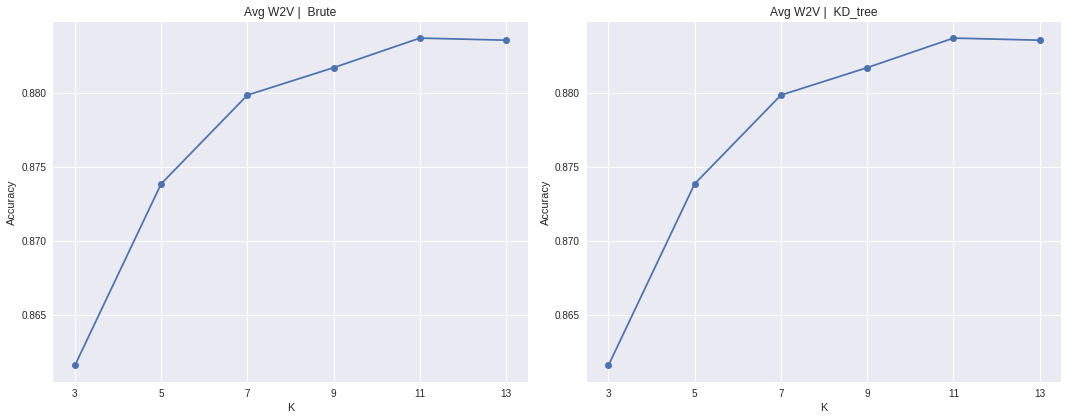

In [157]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('Avg W2V |  Brute')
plt.plot(list(k_vs_acc_brute_w2v.keys()), list(k_vs_acc_brute_w2v.values()), marker='o')
plt.xticks([3,5,7,9,11,13])
plt.xlabel('K')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.title('Avg W2V |  KD_tree')
plt.plot(list(k_vs_acc_kd_w2v.keys()), list(k_vs_acc_kd_w2v.values()), marker='o')
plt.xticks([3,5,7,9,11,13])
plt.xlabel('K')
plt.ylabel('Accuracy')

plt.tight_layout()



---



### Tfidf weighted W2V

Similar to the last technique, only difference being each review is a Tfidf weighted sum of all the words in the review.

In [0]:
features = tfidf_vec.get_feature_names()

In [0]:
corpus_tfidf_weighted_w2v = np.zeros(shape=(50))
review_number = 0

for review in df['cleaned_text'].values:
    review_vector_tfidf_weighted = np.zeros(shape=(50))
    tfidf_sum = 0
    for word in review.decode('utf-8').split():
        try:
            tfidf_value = tfidf_vector[review_number, features.index(word)]
            review_vector_tfidf_weighted += w2v_model.wv[word] * tfidf_value
            tfidf_sum += tfidf_value
            
        except KeyError:
            continue
    
    review_number += 1
    
    review_vector_tfidf_weighted /= tfidf_sum
    corpus_tfidf_weighted_w2v=np.vstack((corpus_tfidf_weighted_w2v,review_vector_tfidf_weighted))
    
corpus_tfidf_weighted_w2v = np.delete(corpus_tfidf_weighted_w2v, 0, axis=0)

In [160]:
corpus_tfidf_weighted_w2v.shape

(10000, 50)

In [0]:
X_train,X_test, y_train, y_test = train_test_split(corpus_tfidf_weighted_w2v, y, test_size=0.3,random_state=3,shuffle=False)

In [162]:
k_vs_acc_brute_tfidf_w2v = k_versus_accuracy(X_train, y_train, alg='brute')
print('K vs Accuracy for W2V using Brute algorithm...\n {}'.format(k_vs_acc_brute_tfidf_w2v))

K vs Accuracy for W2V using Brute algorithm...
 {3: 0.8597142857142857, 5: 0.8721428571428571, 7: 0.8779999999999999, 9: 0.878857142857143, 11: 0.8807142857142857, 13: 0.8824285714285715}


In [163]:
k_vs_acc_kd_tfidf_w2v = k_versus_accuracy(X_train, y_train, alg='kd_tree')
print('K vs Accuracy for W2V using Brute algorithm...\n {}'.format(k_vs_acc_kd_tfidf_w2v))

K vs Accuracy for W2V using Brute algorithm...
 {3: 0.8597142857142857, 5: 0.8721428571428571, 7: 0.8779999999999999, 9: 0.878857142857143, 11: 0.8807142857142857, 13: 0.8824285714285715}


In [164]:
knn = KNeighborsClassifier(n_neighbors = 11, weights = 'uniform', algorithm = 'kd_tree')
knn.fit(X_train, y_train)
print('Accuracy for Tfidf weighted W2V')
print('Accuracy on train data: {}'.format(knn.score(X_train, y_train)))
print('Accuracy on test data: {}'.format(knn.score(X_test, y_test)))

Accuracy for Tfidf weighted W2V
Accuracy on train data: 0.8904285714285715
Accuracy on test data: 0.8933333333333333


Plot observations.

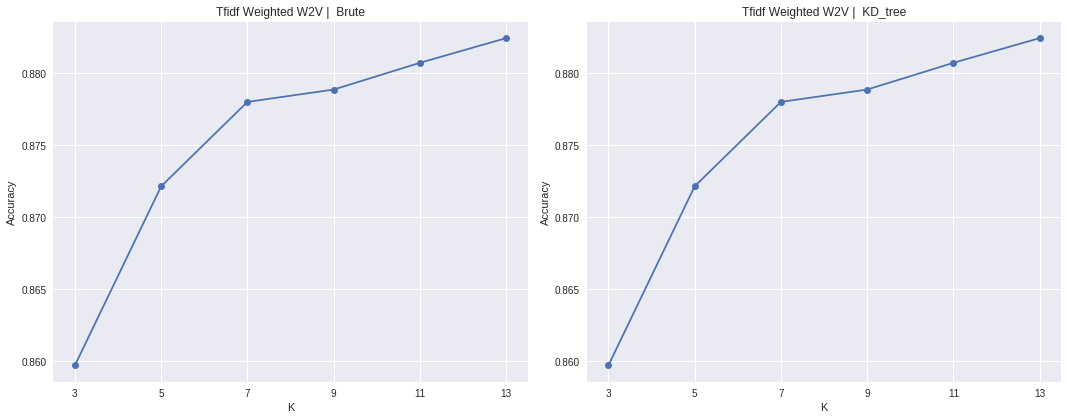

In [165]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title('Tfidf Weighted W2V |  Brute')
plt.plot(list(k_vs_acc_brute_tfidf_w2v.keys()), list(k_vs_acc_brute_tfidf_w2v.values()), marker='o')
plt.xticks([3,5,7,9,11,13])
plt.xlabel('K')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.title('Tfidf Weighted W2V |  KD_tree')
plt.plot(list(k_vs_acc_kd_tfidf_w2v.keys()), list(k_vs_acc_kd_tfidf_w2v.values()), marker='o')
plt.xticks([3,5,7,9,11,13])
plt.xlabel('K')
plt.ylabel('Accuracy')

plt.tight_layout()

# Conclusion

* Continuing the study of the Amazon Food Reviews dataset, I applied KNN on various vector representations of text data, to classify the reviews into positive/negative.

* Although accuracy > 85% can be generally considered good, this is not the case here, because the dataset is heavily biased towards positve reviews. Therefore, accuracy is not the best metric to use in this situation.